# 조건별 작물 추천 모델링 만들기
데이터 출처 : https://www.kaggle.com/datasets/madhuraatmarambhagat/crop-recommendation-dataset?select=Crop_recommendation.csv

In [1]:
# PySpark 세션을 생성합니다.
# "miniproject1"이라는 이름으로 Spark 애플리케이션을 시작하고, getOrCreate()를 사용하여 기존 세션이 있으면 재사용합니다.
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("miniproject1").getOrCreate()

In [2]:
# 데이터 파일의 경로를 설정합니다.
file_path = 'file:////home/jovyan/work/start_spark/learning_spark_data/Crop_recommendation.csv'
file_path

'file:////home/jovyan/work/start_spark/learning_spark_data/Crop_recommendation.csv'

In [3]:
# CSV 파일을 읽어 Spark DataFrame을 생성합니다.
# inferSchema=True: 데이터의 스키마(데이터 타입)를 자동으로 추론합니다.
# header=True: 첫 번째 행을 헤더로 인식합니다.
# printSchema()를 사용하여 DataFrame의 스키마를 출력합니다.
df = spark.read.csv(file_path, inferSchema=True, header=True)
df.printSchema()

root
 |-- N: integer (nullable = true)
 |-- P: integer (nullable = true)
 |-- K: integer (nullable = true)
 |-- temperature: double (nullable = true)
 |-- humidity: double (nullable = true)
 |-- ph: double (nullable = true)
 |-- rainfall: double (nullable = true)
 |-- label: string (nullable = true)



In [4]:
# DataFrame의 상위 5개 행을 출력하여 데이터 구조를 확인합니다.
df.show(5)

+---+---+---+-----------+-----------+-----------------+-----------+-----+
|  N|  P|  K|temperature|   humidity|               ph|   rainfall|label|
+---+---+---+-----------+-----------+-----------------+-----------+-----+
| 90| 42| 43|20.87974371|82.00274423|6.502985292000001|202.9355362| rice|
| 85| 58| 41|21.77046169|80.31964408|      7.038096361|226.6555374| rice|
| 60| 55| 44|23.00445915| 82.3207629|      7.840207144|263.9642476| rice|
| 74| 35| 40|26.49109635|80.15836264|      6.980400905|242.8640342| rice|
| 78| 42| 42|20.13017482|81.60487287|      7.628472891|262.7173405| rice|
+---+---+---+-----------+-----------+-----------------+-----------+-----+
only showing top 5 rows



In [5]:
# 각 컬럼에 Null 또는 NaN(숫자 형태의 결측값)이 있는지 확인하고 개수를 계산합니다.
# isnan() 함수는 숫자형 컬럼에 대해서만 작동하므로, isNull()과 함께 사용합니다.
# 결과 DataFrame에는 각 컬럼의 결측값 개수가 포함됩니다.
from pyspark.sql.functions import col, sum, when, isnan
null_counts = df.select(
                    [
                        sum(when(col(c).isNull() | isnan(c), 1).otherwise(0)).alias(c)
                        for c in df.columns
                    ]
                )
null_counts.show()

+---+---+---+-----------+--------+---+--------+-----+
|  N|  P|  K|temperature|humidity| ph|rainfall|label|
+---+---+---+-----------+--------+---+--------+-----+
|  0|  0|  0|          0|       0|  0|       0|    0|
+---+---+---+-----------+--------+---+--------+-----+



In [6]:
# ML 모델 구축에 필요한 PySpark ML 라이브러리를 임포트합니다.
# LogisticRegression: 로지스틱 회귀 모델
# BinaryClassificationEvaluator: 이진 분류 모델 평가 도구 (이 노트북에서는 사용되지 않았지만 임포트되어 있음)
# VectorAssembler: 여러 컬럼을 단일 벡터 컬럼으로 변환
# StringIndexer: 문자열 라벨을 숫자 인덱스로 변환
# OneHotEncoder: 원-핫 인코딩 (이 노트북에서는 사용되지 않았음)
# StandardScaler: 데이터 표준화 (평균 0, 분산 1)
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, StandardScaler

In [7]:
# 데이터를 훈련 세트(80%)와 테스트 세트(20%)로 무작위 분할합니다.
# seed=64: 재현성을 위해 시드를 고정합니다.
train_data, test_data = df.randomSplit([0.8,0.2], seed=64)

In [8]:
# 파이프라인(Pipeline)에 사용할 스테이지(단계)를 저장할 빈 리스트를 생성합니다.
stages = []

In [9]:
# 'label' 컬럼(문자열)을 'labelIndexer'라는 숫자형 인덱스로 변환하는 StringIndexer 스테이지를 정의하고 파이프라인에 추가합니다.
labelIndexer = StringIndexer(inputCol='label',outputCol = 'labelIndexer')
stages += [labelIndexer]

In [10]:
# 숫자형 특성들에 대해 표준화(Standardization)를 수행하는 파이프라인 스테이지를 생성합니다.
# num_features 리스트에 있는 각 컬럼에 대해 VectorAssembler와 StandardScaler를 적용합니다.
# VectorAssembler: 각 숫자 컬럼을 단일 벡터로 만듭니다.
# StandardScaler: 해당 벡터를 표준화(Z-score normalization)합니다.
num_features = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
for num in num_features:
    num_assembler = VectorAssembler(inputCols=[num], outputCol=num+'_vector')
    num_scaler = StandardScaler(inputCol=num_assembler.getOutputCol(), outputCol=num+'_scaled')
    stages += [num_assembler, num_scaler]

In [11]:
# 표준화된 모든 숫자 특성 컬럼의 이름을 assembler_input 리스트에 저장합니다.
assembler_input = [num+'_scaled' for num in num_features]

In [12]:
# 표준화된 모든 특성 컬럼들을 'feature_vector'라는 하나의 벡터 컬럼으로 합치는 VectorAssembler 스테이지를 정의하고 파이프라인에 추가합니다.
assembler = VectorAssembler(
    inputCols= assembler_input,
    outputCol= 'feature_vector'
)
stages += [assembler]

In [13]:
# 앞서 정의한 모든 스테이지(StringIndexer, VectorAssembler, StandardScaler)를 포함하는 PySpark Pipeline을 생성합니다.
# fit()을 사용하여 훈련 데이터에 파이프라인을 학습시키고, transform()으로 훈련 데이터에 변환을 적용합니다.
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=stages)
fitted_transform = pipeline.fit(train_data)
vtrain_data = fitted_transform.transform(train_data)

In [14]:
# 로지스틱 회귀 모델 객체를 생성하고, 훈련 데이터에 맞춰 모델을 학습시킵니다.
# featuresCol='feature_vector': 특성 컬럼으로 사용할 컬럼을 지정합니다.
# labelCol='labelIndexer': 라벨 컬럼으로 사용할 컬럼을 지정합니다.
lr = LogisticRegression(featuresCol='feature_vector', labelCol='labelIndexer')
lr_model = lr.fit(vtrain_data)

In [15]:
# 테스트 데이터에도 훈련 데이터에 학습된 파이프라인 변환을 적용합니다.
vtest_data = fitted_transform.transform(test_data)
# 학습된 로지스틱 회귀 모델을 사용하여 테스트 데이터에 대한 예측을 수행합니다.
pred = lr_model.transform(vtest_data)

In [16]:
# 예측 결과 DataFrame에서 라벨 인덱스와 예측값을 상위 5개 출력하여 확인합니다.
pred.select('labelIndexer', 'prediction').show(5)

+------------+----------+
|labelIndexer|prediction|
+------------+----------+
|         4.0|       4.0|
|         7.0|       7.0|
|         7.0|       7.0|
|        15.0|      15.0|
|        20.0|      20.0|
+------------+----------+
only showing top 5 rows



In [17]:
# 예측값과 실제 라벨이 일치하는지 비교하는 'correct' 컬럼을 생성합니다.
# 일치하면 1, 불일치하면 0으로 설정합니다.
# 예측이 틀린 경우(correct=0)의 개수를 계산하여 출력합니다.
from pyspark.sql.functions import expr
comp = pred.withColumn('correct', expr('case when labelIndexer = prediction then 1 else 0 end'))
comp.where('correct=0').count()

9

In [18]:
# 전체 정확도(accuracy)를 계산합니다.
# 'correct' 컬럼의 평균을 계산하여 정확도를 나타냅니다.
comp.selectExpr('avg(correct) as accuracy').collect()[0]['accuracy']

0.9803063457330415

In [19]:
# 각 작물(label)별 정확도를 계산하여 출력합니다.
# 먼저 최대 'labelIndexer' 값을 찾습니다.
# 각 라벨 인덱스(i)에 대해 필터링하고 'correct' 컬럼의 평균을 계산합니다.
# 해당 인덱스에 해당하는 작물 이름을 찾아 정확도와 함께 출력합니다.
from pyspark.sql.functions import max
max_index = vtrain_data.select(max('labelIndexer')).collect()[0][0]
for i in range(int(max_index) + 1):
    acc = comp.filter(col('labelIndexer') == i).selectExpr('avg(correct) as accuracy').collect()[0]['accuracy']
    crop_name = vtrain_data.select('label').filter(col('labelIndexer') == i).collect()[0][0]
    print(f'{crop_name} : {acc}')

lentil : 1.0
maize : 1.0
orange : 1.0
grapes : 1.0
mango : 1.0
muskmelon : 1.0
pomegranate : 1.0
coconut : 1.0
jute : 0.9
cotton : 1.0
papaya : 0.9523809523809523
rice : 0.9047619047619048
banana : 1.0
chickpea : 0.9090909090909091
pigeonpeas : 1.0
kidneybeans : 1.0
blackgram : 0.9583333333333334
coffee : 1.0
mungbean : 1.0
watermelon : 1.0
apple : 1.0
mothbeans : 0.9642857142857143


In [20]:
# pH 컬럼의 이상치를 Z-score 방법을 사용하여 제거하는 과정입니다.
# 1. pH 컬럼의 평균(mean_val)과 표준편차(stddev_val)를 계산합니다.
# 2. Z-score 임계값(threshold)을 3.0으로 설정합니다 (평균에서 3 표준편차 이상 떨어진 값).
# 3. Z-score 임계값을 벗어나는 이상치의 개수를 계산합니다.
# 4. 이상치를 제거한 새로운 DataFrame(df_no_outliers_zscore)을 생성합니다.
from pyspark.sql.functions import col, avg, stddev
mean_val = df.select(avg("ph")).collect()[0][0]
stddev_val = df.select(stddev("ph")).collect()[0][0]

# 2. Z-score 임계값 설정
threshold = 3.0


drop_count = df.filter(
    (col("ph") < (mean_val - threshold * stddev_val)) |
    (col("ph") > (mean_val + threshold * stddev_val))
).count()
# 3. 이상치 제거
df_no_outliers_zscore = df.filter(
    (col("ph") >= (mean_val - threshold * stddev_val)) &
    (col("ph") <= (mean_val + threshold * stddev_val))
)
drop_count

30

In [21]:
# 이상치가 제거된 데이터(df_no_outliers_zscore)를 훈련 세트(80%)와 테스트 세트(20%)로 무작위 분할합니다.
# seed=64: 재현성을 위해 시드를 고정합니다.
ztrain_data, ztest_data = df_no_outliers_zscore.randomSplit([0.8,0.2], seed=64)

In [22]:
# 이상치가 제거된 훈련 데이터(ztrain_data)를 사용하여 파이프라인을 다시 학습시키고 변환을 적용합니다.
pipeline = Pipeline(stages=stages)
fitted_transform = pipeline.fit(ztrain_data)
vztrain_data = fitted_transform.transform(ztrain_data)

In [23]:
# 로지스틱 회귀 모델을 생성하고, 이상치가 제거된 훈련 데이터(vztrain_data)로 모델을 다시 학습시킵니다.
lr = LogisticRegression(featuresCol='feature_vector', labelCol='labelIndexer')
lr_model = lr.fit(vztrain_data)

In [24]:
# 이상치가 제거된 테스트 데이터(ztest_data)에 파이프라인 변환을 적용하고, 모델을 사용하여 예측을 수행합니다.
vztest_data = fitted_transform.transform(ztest_data)
zpred = lr_model.transform(vztest_data)

In [25]:
# 이상치가 제거된 데이터로 예측한 결과의 상위 5개 라벨 인덱스와 예측값을 출력합니다.
zpred.select('labelIndexer', 'prediction').show(5)

+------------+----------+
|labelIndexer|prediction|
+------------+----------+
|         6.0|       6.0|
|         5.0|       5.0|
|         5.0|       5.0|
|         3.0|       3.0|
|         7.0|       7.0|
+------------+----------+
only showing top 5 rows



In [26]:
# 이상치가 제거된 데이터로 예측한 결과에서, 예측이 틀린 경우(correct=0)의 개수를 계산합니다.
from pyspark.sql.functions import expr
zcomp = zpred.withColumn('correct', expr('case when labelIndexer = prediction then 1 else 0 end'))
zcomp.where('correct=0').count()

5

In [27]:
# 이상치 제거 후의 전체 정확도를 계산하여 출력합니다.
zcomp.selectExpr('avg(correct) as accuracy').collect()[0]['accuracy']

0.9889380530973452

In [28]:
# 이상치 제거 후의 각 작물별 정확도를 계산하여 출력합니다.
for i in range(int(max_index) + 1):
    zacc = zcomp.filter(col('labelIndexer') == i).selectExpr('avg(correct) as accuracy').collect()[0]['accuracy']
    zcrop_name = vztrain_data.select('label').filter(col('labelIndexer') == i).collect()[0][0]
    print(f'{zcrop_name} : {zacc}')

lentil : 1.0
maize : 1.0
grapes : 1.0
kidneybeans : 1.0
rice : 0.9444444444444444
coconut : 1.0
mango : 1.0
apple : 1.0
banana : 1.0
blackgram : 0.9523809523809523
pomegranate : 1.0
watermelon : 1.0
cotton : 1.0
papaya : 1.0
coffee : 1.0
jute : 0.875
mungbean : 1.0
muskmelon : 1.0
orange : 1.0
pigeonpeas : 1.0
chickpea : 1.0
mothbeans : 1.0


In [29]:
# 1. 이상치 제거 전 작물별 정확도 데이터 추출
accuracy_before = {}
for i in range(int(max_index) + 1):
    acc = comp.filter(col('labelIndexer') == i).selectExpr('avg(correct) as accuracy').collect()[0]['accuracy']
    crop_name = comp.select('label').filter(col('labelIndexer') == i).collect()[0][0]
    accuracy_before[crop_name] = acc

In [30]:
# 2. 이상치 제거 후 작물별 정확도 데이터 추출
accuracy_after = {}
for i in range(int(max_index) + 1):
    zacc = zcomp.filter(col('labelIndexer') == i).selectExpr('avg(correct) as accuracy').collect()[0]['accuracy']
    zcrop_name = zcomp.select('label').filter(col('labelIndexer') == i).collect()[0][0]
    accuracy_after[zcrop_name] = zacc

In [31]:
# 3. 두 딕셔너리를 활용하여 Pandas DataFrame 생성
import pandas as pd

df_acc_before = pd.DataFrame(list(accuracy_before.items()), columns=['Crop', 'Accuracy_Before'])
df_acc_after = pd.DataFrame(list(accuracy_after.items()), columns=['Crop', 'Accuracy_After'])


In [32]:
# 4. 두 DataFrame을 'Crop'을 기준으로 병합하여 최종 DataFrame 생성
df_acc = pd.merge(df_acc_before, df_acc_after, on='Crop', how='outer').fillna(0) # 데이터가 없는 경우 0으로 채우기
df_acc

,Crop,Accuracy_Before,Accuracy_After
0,lentil,1.000000,1.000000
1,maize,1.000000,1.000000
2,orange,1.000000,1.000000
3,grapes,1.000000,1.000000
4,mango,1.000000,1.000000
5,muskmelon,1.000000,1.000000
6,pomegranate,1.000000,1.000000
7,coconut,1.000000,1.000000
8,jute,0.900000,0.875000
9,cotton,1.000000,1.000000


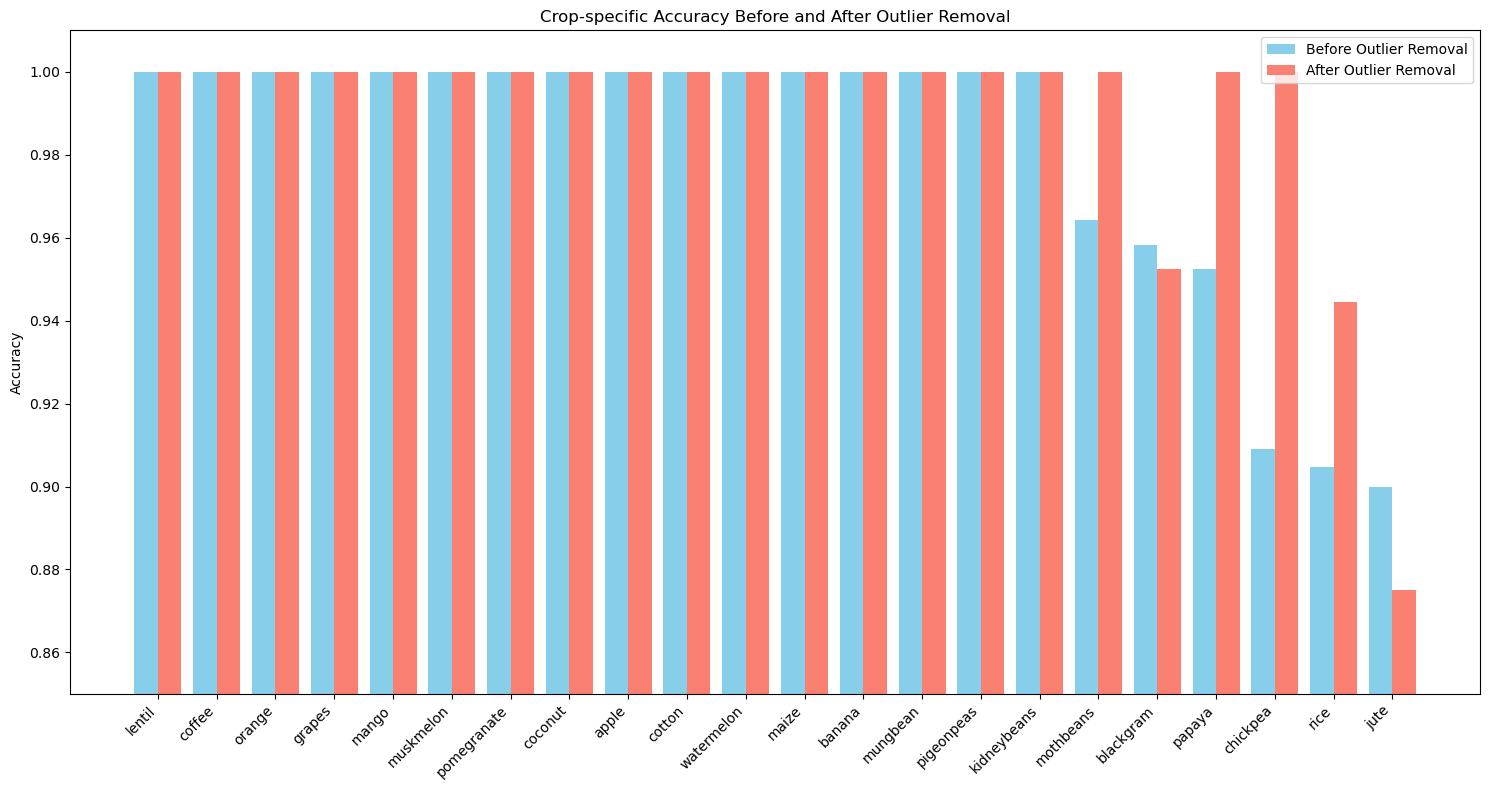

In [33]:
import matplotlib.pyplot as plt
import numpy as np

df_acc_sorted = df_acc.sort_values(by='Accuracy_Before', ascending=False)

# 시각화 설정
fig, ax = plt.subplots(figsize=(15, 8))
width = 0.4 # 막대 폭
x = np.arange(len(df_acc_sorted['Crop']))

# 막대 그래프 그리기
rects1 = ax.bar(x - width/2, df_acc_sorted['Accuracy_Before'], width, label='Before Outlier Removal', color='skyblue')
rects2 = ax.bar(x + width/2, df_acc_sorted['Accuracy_After'], width, label='After Outlier Removal', color='salmon')

# 그래프 제목과 라벨 설정
ax.set_ylabel('Accuracy')
ax.set_title('Crop-specific Accuracy Before and After Outlier Removal')
ax.set_xticks(x)
ax.set_xticklabels(df_acc_sorted['Crop'], rotation=45, ha="right")
ax.legend()

# y축 값 범위를 0.85-1.01로 설정
ax.set_ylim(0.85, 1.01) 

plt.tight_layout()
plt.show()

In [34]:
#사용된 spark 세션을 종료합니다.
spark.stop()